# Explore NHS England Synthetic A&E data

In my first experiment I want to try generating some synthetic patients notes. I start with some patient parameters provided by synthetic data. NHS England prepared a synthetic dataset of A&E presentations. A blog post about it is [here](https://open-innovations.org/blog/2019-01-24-exploring-methods-for-creating-synthetic-a-e-data). The dataset can be accessed from [this website](https://data.england.nhs.uk/dataset/a-e-synthetic-data/resource/81b068e5-6501-4840-a880-a8e7aa56890e#).

Unfortunately, there is no data dictionary. Therefore, here I only use data which can be intuively understood ie:  

* Age_Band
* AE_Arrive_HourOfDay
* AE_Time_Mins
* Admitted_Flag - assuming 1 means yes
* ICD10_Chapter_Code - for more see [Wikipedia](https://en.wikipedia.org/wiki/ICD-10)
* Length_Of_Stay_Days

Here I do some exploration of the data. 

## Set up

In [2]:
# Reload functions every time
%load_ext autoreload 
%autoreload 2

In [17]:
# Load libraries
import sys
import os
import pandas as pd
from pathlib import Path

import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


# Import the variables that have been set in the init.py folder in the root directory
# These include a constant called PROJECT_ROOT which stores the absolute path to this folder
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
import init
PROJECT_ROOT = os.getenv("PROJECT_ROOT")

# Add the src folder to sys path, so that the application knows to look there for libraries
sys.path.append(str(Path(PROJECT_ROOT) / 'src'))

# Import function to load data
from data_ingestion.load_data import load_nhse_data


## Load data

Here the function called load_file()  

* checks if the NHS England datset has already been saved in a local folder called data_store in a parquet format; if so the function returns it
* if not, it checks for the zip file from the NHSE website and if not downloads it, unzips it and saves it 
* the file is unzipped to csv and read as as pandas dataframe and saved to parquet format
* joins with a [ICD-10 look up file](../src/data_ingestion/icd10_lookup.csv) downloaded from Wikipedia to add the title associated with the ICD-10 chapter, for readability

In [21]:
ed = load_nhse_data(admitted_only=False)
# ed.head()

In [22]:
print(min(ed.AE_Arrive_Date))
print(max(ed.AE_Arrive_Date))

2014-03-23 00:00:00
2018-03-22 00:00:00


As noted above, we will only use the following columns initially:

In [4]:
# ed[['Age_Band', 'AE_Arrive_HourOfDay', 'AE_Time_Mins', 'Admitted_Flag', 'Length_Of_Stay_Days', 'ICD10_Chapter_Code', 'Title']].head()

## Explore the dataset

Among the variables with interpretable names, the following plots show their distributions

### Admitted flag

We will use this to determine which patients were admitted

In [25]:
ed.Admitted_Flag.value_counts()

Admitted_Flag
1.0    9636520
0.0        903
Name: count, dtype: int64

### Length of stay in hospital

From above, we can see that the Admitted_Flag includes almost everyone. 

Therefore length of stay may be a better way to identify inpatients. There are some very long staying patients, as the left hand boxplot shows. The right hand plot filter to include only visits of less than 25 days. Among these, the median length of stay is 5 days. 

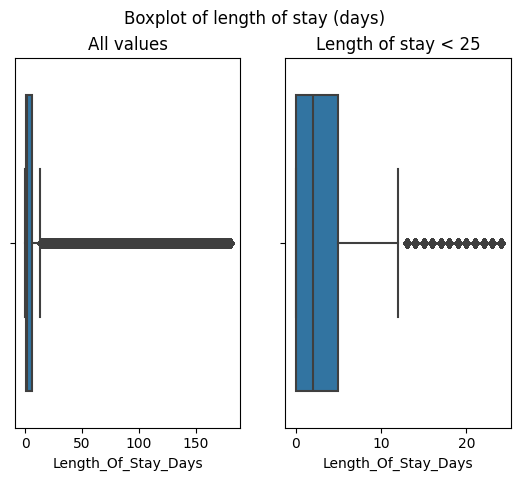

In [26]:
import matplotlib.pyplot as plt

# Create two subplots
fig, axes = plt.subplots(1, 2)

# Left plot: All values
sns.boxplot(x='Length_Of_Stay_Days', data=ed, ax=axes[0])
axes[0].set_title('All values')

# Right plot: Length_Of_Stay_Days < 25
sns.boxplot(x='Length_Of_Stay_Days', data=ed[ed['Length_Of_Stay_Days'] < 25], ax=axes[1])
axes[1].set_title('Length of stay < 25')

fig.suptitle('Boxplot of length of stay (days)')

plt.show()


From the above, we can see a large proportion with length of stay of 1. We'll remove these plus anyy with an Admitted_Flag of zero

In [27]:
ed = ed.query("Length_Of_Stay_Days > 1 and Admitted_Flag == 1")

### Age band

Histogram shows a weighting towards older patients, following the typical distribution of A&E patients in the UK

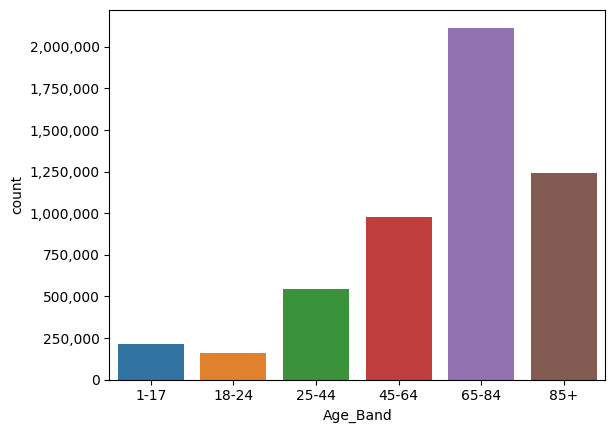

In [28]:
from matplotlib.ticker import FuncFormatter

# Set 'Age_Band' as ordered categorical data
ed['Age_Band'] = pd.Categorical(ed['Age_Band'], categories=['1-17', '18-24', '25-44', '45-64', '65-84', '85+'], ordered=True)

# Plot count of each age band
sns.countplot(x='Age_Band', data=ed, order=['1-17', '18-24', '25-44', '45-64', '65-84', '85+'])

# Format y-axis labels as plain numbers
plt.ticklabel_format(style='plain', axis='y')

# Add comma separator for y-axis labels
ax = plt.gca()
ax.get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))


### Time in A&E

The A&E targets to admit people within four hours are very apparent from the distribution of the variable showing time spent in A&E. These data were collected between 2014 and 2018 in the UK. Since then, the four hour targets are more often missed  

<Axes: xlabel='AE_Time_Mins', ylabel='Count'>

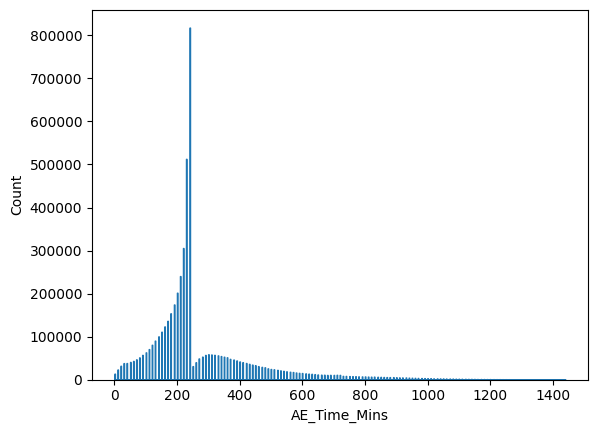

In [29]:
sns.histplot(ed['AE_Time_Mins'], element='step')


### Hour of arrival at A&E

Arrivals are at the their maximum in the morning and early afternoon. 

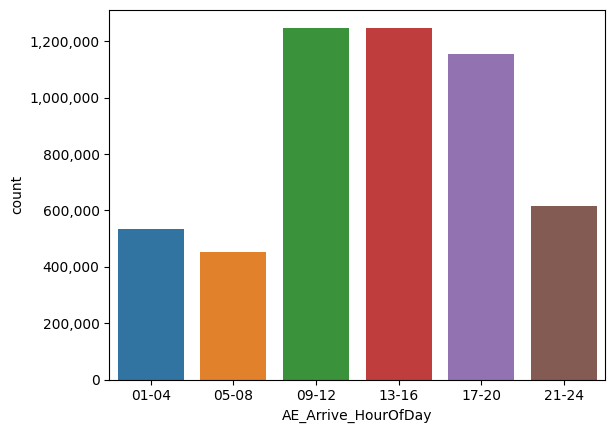

In [30]:
categories_order = ['01-04', '05-08', '09-12', '13-16', '17-20', '21-24']
ed['AE_Arrive_HourOfDay'] = pd.Categorical(ed['AE_Arrive_HourOfDay'], categories=categories_order, ordered=True)
sns.countplot(x='AE_Arrive_HourOfDay', data=ed, order=categories_order)

# Format y-axis labels as plain numbers
plt.ticklabel_format(style='plain', axis='y')

# Add comma separator for y-axis labels
ax = plt.gca()
ax.get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))


### Presenting condition

Each patient has a ICD10 code. Here they are shown with the associated title from https://en.wikipedia.org/wiki/ICD-10. The majority are respiratory conditions. 

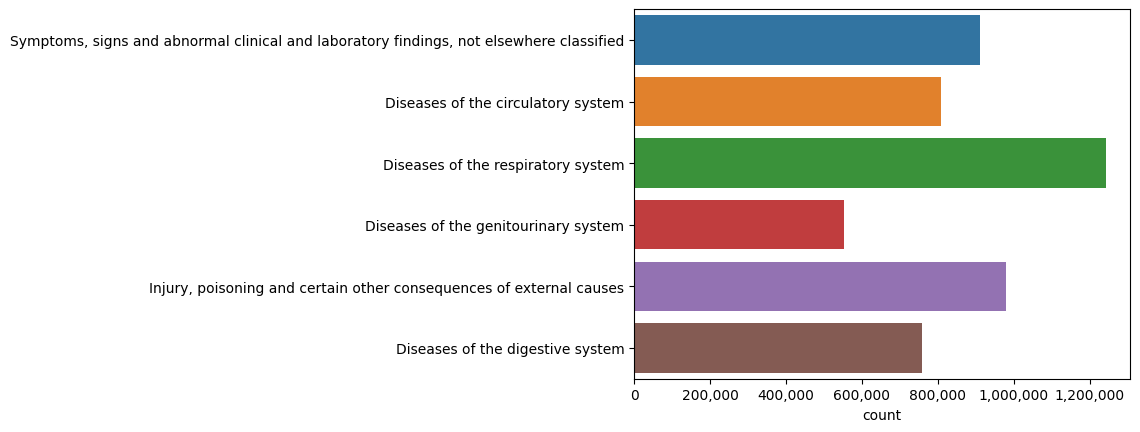

In [31]:
sns.countplot(y='Title', data=ed)
plt.ylabel('')

plt.ticklabel_format(style='plain', axis='x')
ax = plt.gca()
ax.get_xaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))

plt.show();


